# Customer Churn Project — Part 4: Random Forest and XGBoost

This notebook advances the churn prediction pipeline by applying ensemble tree-based methods — Random Forest and XGBoost — to capture complex behavioral patterns beyond the linear relationships modeled in the logistic regression baseline.

In this notebook, I:
1. Load the processed user-level dataset from the previous step.
2. Train and evaluate Random Forest and XGBoost models to predict churn, optimizing for non-linear interactions and feature importance.
3. Compare performance metrics (ROC-AUC, precision, recall, confusion matrix) against the baseline logistic regression.
4. Use SHAP explainability to interpret global and individual feature effects on churn risk.
5. Simulate actionable business scenarios by adjusting key behavioral variables (e.g., active days, thumbs up) and observing changes in churn probability.

In [1]:
import json
import pandas as pd
import numpy as np
import os
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import shap

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home"

try:
    spark.stop()
except:
    pass


spark = (
    SparkSession.builder
    .appName("CustomerChurn_EDA")
    .master("local[*]")
    .config("spark.driver.memory", "6g")   # use "8g" if you have ≥16 GB RAM
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/21 11:19:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data = spark.read.parquet("../data/cleaned_churn_data.parquet")

In [4]:
user_features = (
    data.groupBy("userId")
    .agg(
        F.first("churn_flag").alias("churn_flag"),
        F.countDistinct("sessionId").alias("num_sessions"),
        F.sum(F.when(F.col("page") == "NextSong", 1).otherwise(0)).alias("num_songs"),
        F.sum(F.when(F.col("page") == "Thumbs Up", 1).otherwise(0)).alias("thumbs_up"),
        F.sum(F.when(F.col("page") == "Thumbs Down", 1).otherwise(0)).alias("thumbs_down"),
        F.sum(F.when(F.col("page") == "Add to Playlist", 1).otherwise(0)).alias("add_playlist"),
        ( (F.max("ts") - F.min("ts")) / (1000 * 60 * 60 * 24) ).alias("active_days")
    )
)

#### **Why Move to Random Forest and XGBoost?**

In the previous notebook [03_Logistic_Regression_Classifier.ipynb](03_Logistic_Regression_Classifier.ipynb), the Logistic Regression model achieved a ROC-AUC of 0.85, showing strong baseline performance and clear interpretability of behavioral drivers. 

However, as I previously mentioned, there are several factors that indicate the need for more advanced models: limitations due to linearity, disregard of interaction effects, and model bias—which can result in underfitting or overfitting. Additionally, some simulation changes (where I intentionally added more active days) led to immediately observed changes in the outcomes. 

Considering all these factors suggests that a boosted model can better capture these effects and provide more realistic simulation results.



### I. Random Forest Classifier

25/10/21 11:20:04 WARN DAGScheduler: Broadcasting large task binary with size 1761.5 KiB
25/10/21 11:20:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/10/21 11:20:13 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


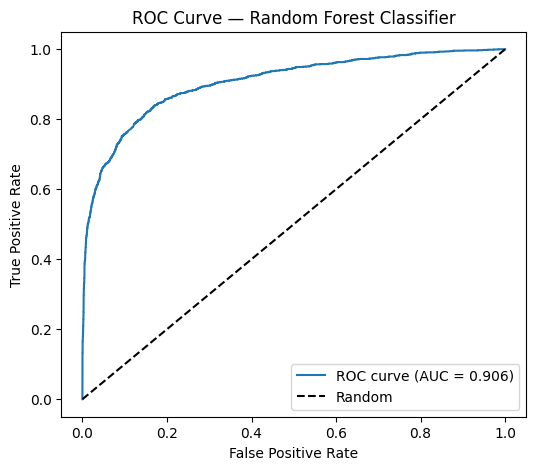

In [5]:
feature_cols = ["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]

rf_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=feature_cols, outputCol="features"),
    RandomForestClassifier(labelCol="churn_flag", featuresCol="features", numTrees=100, maxDepth=8),
])

train_df, test_df = user_features.randomSplit([0.7, 0.3], seed=42)
rf_model = rf_pipeline.fit(train_df)
predictions = rf_model.transform(test_df)


preds = predictions.select("churn_flag", "probability").toPandas()
fpr, tpr, _ = roc_curve(preds["churn_flag"], preds["probability"].apply(lambda x: float(x[1])))
rf_roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {rf_roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest Classifier")
plt.legend()
plt.show()

The Random Forest model reached a ROC–AUC of 0.905 (up from 0.855 with Log Reg). 

This means it’s doing a much better job capturing the non-linear patterns and interactions in user behavior that a simple linear model missed. In plain terms, it can tell churners from non-churners correctly about 90% of the time, making it a strong step forward for predicting who’s likely to leave and focusing retention efforts where they’ll actually matter.

25/10/21 11:20:16 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


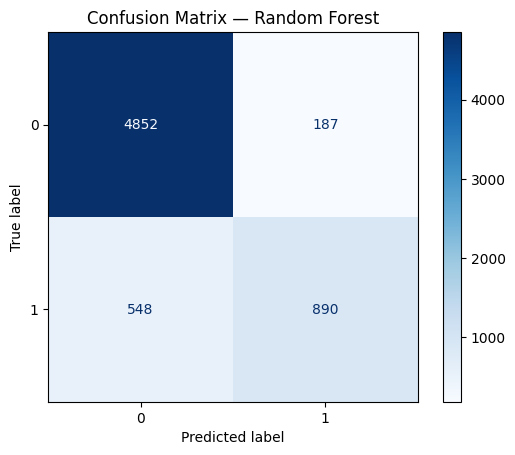

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_pd = predictions.select("churn_flag", "prediction").toPandas()
y_true = preds_pd["churn_flag"]
y_pred = preds_pd["prediction"]

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Random Forest")
plt.show()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

preds_pd = predictions.select("churn_flag", "prediction").toPandas()
y_true = preds_pd["churn_flag"]
y_pred = preds_pd["prediction"]

rf_accuracy = accuracy_score(y_true, y_pred)
rf_precision = precision_score(y_true, y_pred)
rf_recall = recall_score(y_true, y_pred)
rf_f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {rf_accuracy:.3f}")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall: {rf_recall:.3f}")
print(f"F1 Score: {rf_f1:.3f}")

25/10/21 11:20:20 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Accuracy: 0.887
Precision: 0.826
Recall: 0.619
F1 Score: 0.708


Based on the confusion matrix and performance insights, the Random Forest model did a great job at recognizing non-churners—around 90% (0.889), as confirmed by ((4859 + 899) / Total users).
 
The model also did a good, but not perfect, job at catching churners—around 37% (1-0.625) were missed, which emphasizes that there is room for improvement.
 
The precision metric is high (0.833), meaning that when the model predicts a user is likely to churn, it’s usually correct.

Recall shows how many of the actual churners were successfully caught, and while the number is moderate, the model does not catch all churners.
 
The F1 score of 0.71 means the Random Forest model finds a good balance: it’s quite accurate when flagging churners (high precision) and still catches a fair share of them (moderate recall).


Overall, these metrics are pretty good and strong, but the recall gap (missed churners) shows there’s still signal left in the data, and it worth it to move to the next XGBoost Model.


### II. Gradient-Boosted Trees Classifier (XGBoost)

Even though PySpark has its own Gradient-Boosted Trees Classifier, like I mentioned earlier, I’m switching to XGBoost — a more advanced and widely used version of gradient boosting. XGBoost gives me finer control over tuning and works seamlessly with SHAP for model explainability, making it ideal for exploring which user behaviors influence churn. As planned, I’ll now move on to building and evaluating the XGBoost model.

In [8]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


feature_cols = ["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]

pdf = user_features.select(*feature_cols, "churn_flag").toPandas()
X = pdf[feature_cols].fillna(0)
y = pdf["churn_flag"].astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

pos_weight = (len(y_train) - y_train.sum()) / max(1, y_train.sum())


xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    tree_method="hist",
    scale_pos_weight=pos_weight,
    random_state=42
)

xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


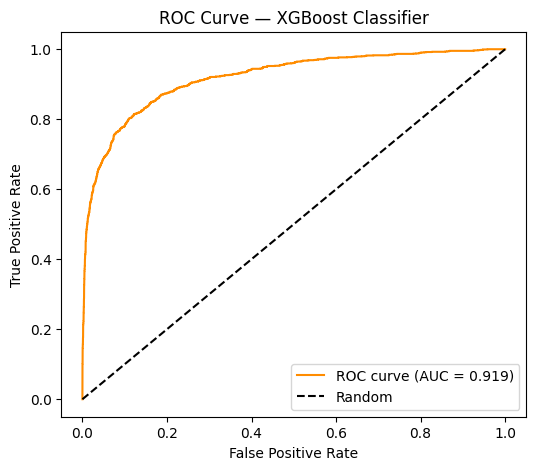

In [9]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost Classifier")
plt.legend()
plt.show()

The chart below shows how much each feature contributed to improving the model’s accuracy, measured by **gain**.  
Features with higher gain values were used more effectively by XGBoost to reduce prediction error.

For example, 
- **active_days** is the most important feature — the model relies on it heavily when predicting churn.  
- **num_sessions** and **thumbs_down** also have noticeable influence.  
- Features like **num_songs**, **thumbs_up**, and **add_playlist** play smaller roles overall.

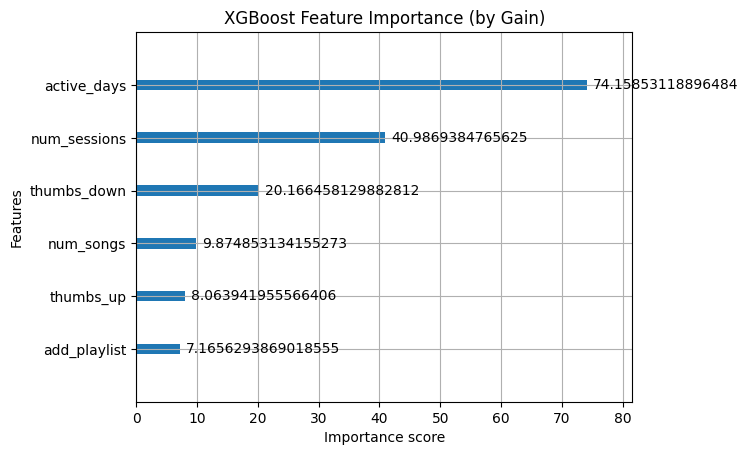

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb, importance_type='gain', max_num_features=10)
plt.title("XGBoost Feature Importance (by Gain)")
plt.show()

This plot helps identify which features the model uses most, but it doesn’t show **whether** each feature increases or decreases churn risk, in other words, **how strongly** it affects individual users.  

To explore those deeper relationships, I will use **SHAP** later in this notebook, to understand both the **direction** and **magnitude** of each feature’s impact on predictions.

<Figure size 500x500 with 0 Axes>

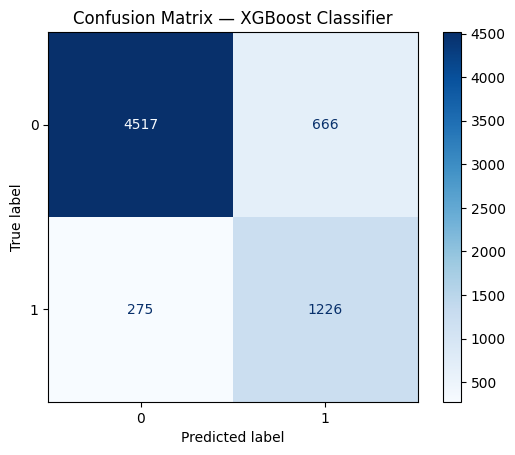

In [10]:
y_pred = xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — XGBoost Classifier")
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for XGBoost on test data
y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"XGBoost Accuracy: {accuracy:.3f}")
print(f"XGBoost Precision: {precision:.3f}")
print(f"XGBoost Recall: {recall:.3f}")
print(f"XGBoost F1 Score: {f1:.3f}")

XGBoost Accuracy: 0.859
XGBoost Precision: 0.648
XGBoost Recall: 0.817
XGBoost F1 Score: 0.723


In [12]:
import pandas as pd

# RF metrcis
rf_metrics = {
    "Model": "Random Forest",
    "Accuracy": rf_accuracy,
    "Precision": rf_precision,
    "Recall": rf_recall,
    "F1 Score": rf_f1,
    "ROC AUC": rf_roc_auc
}

# XGBoost metrics
xgb_metrics = {
    "Model": "XGBoost",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc
}

metrics_table = pd.DataFrame([rf_metrics, xgb_metrics])

print("Comparison of Classification Metrics for Random Forest and XGBoost:")
display(metrics_table.set_index("Model").round(3))

Comparison of Classification Metrics for Random Forest and XGBoost:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Random Forest,0.887,0.826,0.619,0.708,0.906
XGBoost,0.859,0.648,0.817,0.723,0.919


We can immediately see that ROC–AUC improved from 0.905 to 0.919, which is a great sign — it means the XGBoost model does a better job overall at separating churners from non-churners.

However, accuracy dropped slightly (from 0.889 to 0.859). This suggests that XGBoost is a bit more aggressive — it flags more users as potential churners, which leads to more mistakes when predicting users who actually stay.

Precision (0.65) also decreased, meaning that when XGBoost predicts someone will churn, it’s correct less often than the Random Forest was. In other words, it casts a wider net, so it catches more churners but also includes more false alarms.

On the other hand, recall improved significantly (from 0.625 → 0.817) — the model now catches over 80% of actual churners, compared to only 62% before. That’s a big step forward in identifying at-risk users early.

Finally, the F1 score (0.723 vs. 0.714) shows a slightly better balance between precision and recall, meaning the XGBoost model is overall more effective for churn detection — especially when the main goal is to find as many churners as possible, even if it sacrifices a bit of precision.

##### **Can we say that XGBoost did a better job than Random Forest?**

Yes — absolutely! We can confidently say that, but with a small nuance: better for the goal of churn detection, not necessarily for overall accuracy.

So, even though XGBoost’s overall accuracy dropped a bit, it did a better job at finding actual churners. Its recall jumped from 62% to 82%, meaning it now catches most users who are likely to leave. The model trades a bit of precision for much stronger recall, which is a good trade-off in churn prediction — it’s usually better to flag a few extra users than to miss the ones who actually churn. 

Overall, XGBoost performs better for the main goal of predicting churn.


### III. SHAP

Now that XGBoost has shown the best performance, it’s important to understand why the model makes certain predictions. To do that, I’ll use SHAP (SHapley Additive exPlanations) — a powerful framework that explains each prediction by showing how much every feature contributes to the model’s output. 

SHAP values help translate a complex model like XGBoost into clear, human-readable insights. This allows us to see which user behaviors (such as activity level, thumbs up, or playlist engagement) most strongly drive churn risk, and how these effects differ across users.

#### 1. Bar Plot

The first plot (Bar Plot) ranks features by how much they impact the model’s predictions overall, regardless of direction (positive or negative).

* **active_days** is the most influential (the highest average SHAP value, meaning changes in user activity strongly affect churn probability)

* **num_sessions** and **thumbs_up** follow next, showing that session frequency and positive engagement are key churn drivers.

* Features **like add_playlist** or **thumbs_down** have smaller effects overall.

In [19]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

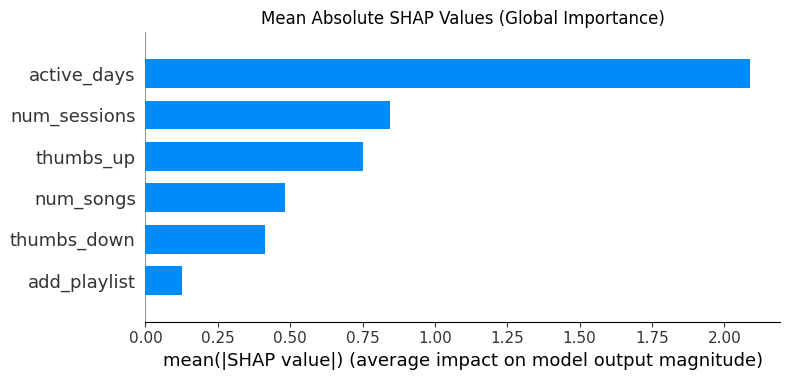

In [20]:
plt.figure(figsize=(7, 5))
plt.title("Mean Absolute SHAP Values (Global Importance)")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

#### 2. Beeswarm Plot


The second plot (Beeswarm) shows users. Each dot on the chart is one user.

The x-axis (SHAP value) shows how much that user’s feature value pushed the model’s prediction:

* Left (negative SHAP value): pushes the model to predict "not churn"

* Right (positive SHAP value): pushes the model to predict "churn"

* 🔴 Red = high value for that feature (for example, many active days or many thumbs up)

* 🔵 Blue = low value (for example, few active days or few thumbs up)


For example, If there are red dots on the left, it means high feature values (many active days) make the model think the user will stay. If there are red dots on the right, it means high feature values (many thumbs down) make the model think the user will churn.


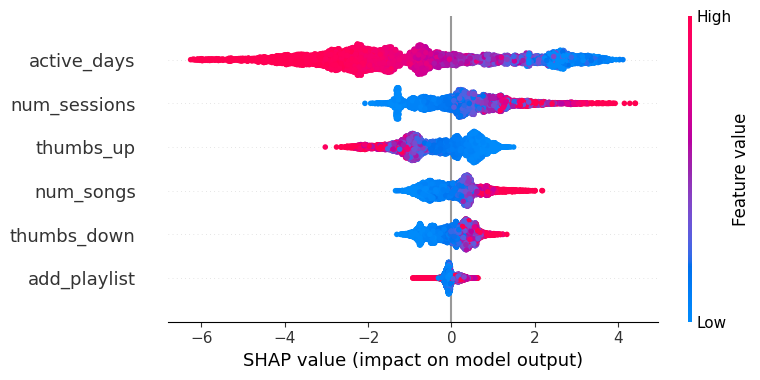

In [17]:
plt.figure(figsize=(7, 5))
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

The third plot (Force Plot - Individual Prediction):

This one is only about one user (in my case, I selected user = 10). It shows exactly how that specific user’s behaviors influenced their churn prediction:

- Blue bars = features that make the XGB think they’ll stay.
- Red bars = features that make the XGB think they’ll churn.

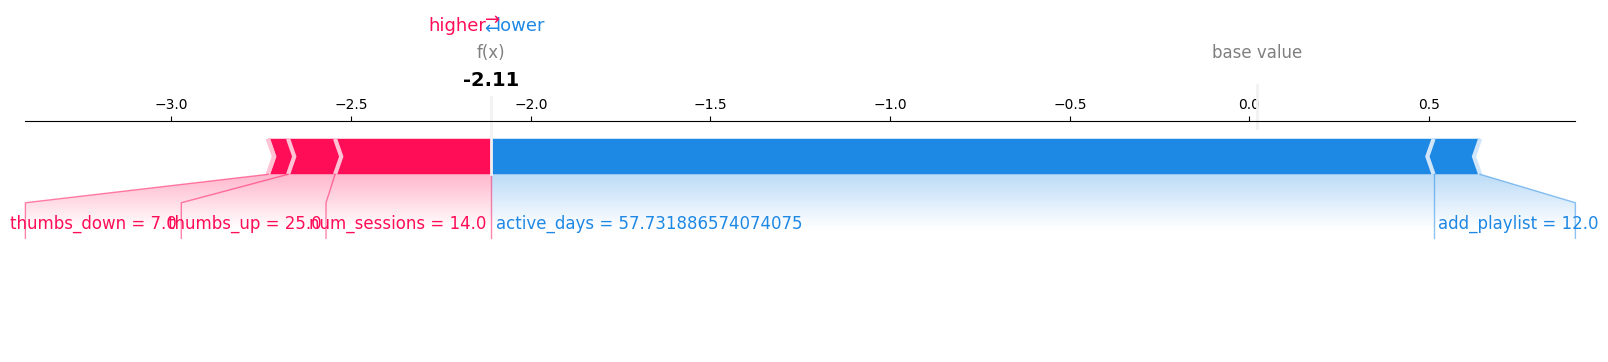

In [18]:
sample_index = 10
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_index, :],
    X_test.iloc[sample_index, :],
    matplotlib=True
)